## Cal-CRAI Metric Calculation for: Natural systems / impervious surfaces
* % of tract with an impervious surface (eg, pavement)

In [1]:
import geopandas as gpd
import s3fs
import pandas as pd
import boto3
import dask_geopandas
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
import sys
import re

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import upload_csv_aws
from scripts.utils.write_metadata import append_metadata

In [5]:
def build_usgs_pqt_file_list(
    path='2b_reproject/natural_systems/ecosystem_condition/usgs'
):
    """ Build a list of USGS parquet URIs contained in S3 folder """
    # initiate empty list for s3 URIs
    all_pqt = []
    bucket = 'ca-climate-index' 
    # initiate s3 session
    session = boto3.Session()
    # use the session to get the resource
    s3 = session.resource('s3')
    my_bucket = s3.Bucket(bucket)
    # iterate through directory
    for obj in my_bucket.objects.filter(
        Prefix=path):
        if obj.key.endswith('.parquet.gzip'):
            all_pqt.append( f's3://{bucket}/{obj.key}')
    return all_pqt

def natural_sort(l): 
    """ Sort list numerically while accounting for missing leading 0s 
    
    Parameters
    ----------
    l: list
        list of strings containing numbers to naturally sort
        
    Acknowledgment
    ----------
    Special thanks to Mark Byers on stackoverflow.
    """
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

# @append_metadata
def percent_tract_impervious(pqt_list, ca_boundaries, run_code=True, varname=''):
    """
    Calculates the percent area of a tract which is developed and impervious as defined by USGS.

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in
    ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
     
    Methods
    -------
    Uses percent of each 30 x 30 m pixel in the USGS data to calculate the impervious area per pixel,
    then sums these pixel areas over each tract and calculates the percentage of the total 
    tract area with with an impervious surface.
    
    Parameters
    ----------
    pqt_list: string
        filename of the large geodataframe shapefile
    ca_boundaries: 
        read-in gpd file of California Census Tracts, converted to California Albers projection
    run_code: bool
        if True, code will run. If false, just metadata file will be updated.

    Script
    ------
    natural_impervious_lands.ipynb
    """
    
    out_fname = 'natural_usgs_impervious_land_metric.csv'

    if run_code == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [out_fname]
        
        gdf_list = []
        for pqt in pqt_list:
            gdf = gpd.read_parquet(pqt)
            gdf["impervious_surface"] = gdf["impervious_surface"]*1e-2
            # percent area of 30 x 30 m pixel which is impervious
            gdf["pixel_area_impervious"] = 900 * gdf["impervious_surface"] 
            agg_gdf = pd.DataFrame(data=gdf["pixel_area_impervious"].groupby(gdf["GEOID"]).sum(),
                         ).rename(columns={"pixel_area_impervious":"tract_area_impervious"})
            gdf_list.append(agg_gdf)
        
        # concatenate list of dataframes into one
        interim_df = pd.concat(gdf_list).reset_index()
        
        # Some tracts were split between multiple parquet partitions,
        # resulting in some GEOIDs having more than one entry, where
        # each entry is only a partial result. 
        # We sum over each GEOID one more time to get one total for each tract.
        summed_df = pd.DataFrame(data=interim_df["tract_area_impervious"].groupby(
            interim_df["GEOID"]).sum()).rename(
            columns={"tract_area_impervious":"total_tract_area_impervious"}
        )
        summed_gdf = pd.merge(ca_boundaries, summed_df, on="GEOID")
        summed_gdf["tract_percent_impervious"] = ( summed_gdf["total_tract_area_impervious"] 
                                                  / summed_gdf["tract_area"] ) * 100
        # one tract has a value of ~101%, likely some error propagation
        # related to the original measurements and area calculations here.
        # We replace this value with 100%.
        summed_gdf['tract_percent_impervious'] = summed_gdf['tract_percent_impervious'].apply(
            lambda x: 100 if x > 100 else x)
        # subset to the data columns we want to save
        metric_gdf = summed_gdf[["GEOID","tract_percent_impervious"]]
        metric_gdf.to_csv(out_fname)
        upload_csv_aws(export_filename, bucket_name, directory)
        return summed_gdf

    else:
        print('Data transformation: previously reprojected data parquets were read in one by one.')
        print('Data transformation: total impervious area of each 30 x 30 m pixel calculated.')
        print('Data transformation: total impervious area summed for each tract.')
        print('Data transformation: percent impervious area calculated for each tract.')
        print('Data transformation: adjust one tract with 101% impervious area to 100%.')
        print(f'{export_filename} uploaded to AWS.')
        return None

In [3]:
# make sorted list of the 45 parquets in the bucket
pqt_list = natural_sort(build_usgs_pqt_file_list())

# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
# keep the columns we need
ca_boundaries = ca_boundaries[["GEOID","geometry"]]
# change to area-preserving CRS
ca_boundaries = ca_boundaries.to_crs("epsg:3310") # CA Albers
# calculate area of each tract
ca_boundaries["tract_area"] = ca_boundaries.area

In [6]:
impervious_gdf = percent_tract_impervious(pqt_list, ca_boundaries, run_code=True, varname='test')

natural_usgs_impervious_land_metric.csv uploaded to AWS


<Axes: >

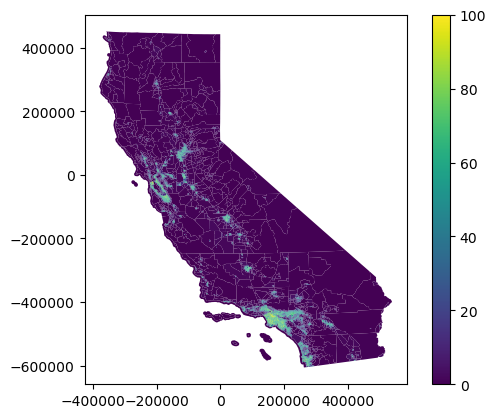

In [7]:
impervious_gdf.plot(column="tract_percent_impervious", legend=True)